In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import datetime

In [8]:
# Cargar datos

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
df = pd.read_csv(
    url,
    sep=';',
    parse_dates={'dt' : ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False,
    na_values=['nan', '?'],
    index_col='dt'
)


C:\Users\User\AppData\Local\Temp/ipykernel_9264/3312383196.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\User\AppData\Local\Temp/ipykernel_9264/3312383196.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


In [9]:
print(df.shape); print('*-*'*20); print(df.info())

(2075259, 7)
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None


In [10]:
# Tomaremos la variable 'Global_active_power' para hacer el análisis de serie de tiempo univariada
df = df['Global_active_power'].resample('D').sum()

In [11]:
df.shape

(1442,)

In [14]:
df

dt
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
                ...   
2010-11-22    2041.536
2010-11-23    1577.536
2010-11-24    1796.248
2010-11-25    1431.164
2010-11-26    1488.104
Freq: D, Name: Global_active_power, Length: 1442, dtype: float64

In [15]:
# Valores faltantes 

df.isna().sum()

0

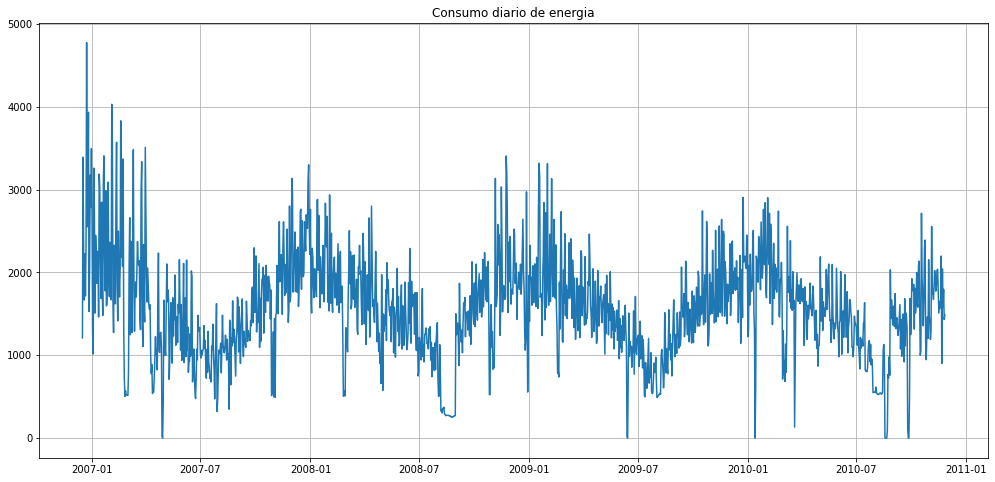

In [16]:
plt.figure(figsize=(17,8))
plt.plot(df)
plt.title('Consumo diario de energia')
plt.grid(True)
plt.show()

## Transformación de la serie de tiempo univariada para poder ser usada en un modelo XGBoost

In [18]:
def transform_series(series, window, horizon): 
    '''
    Transforma una serie de tiempo univariada en un formato adecuado para el aprendizaje supervisado.
    
    Parameters:
    
    series (np.array o pd.Series): La serie de tiempo univariada de entrada.
    
    window (int):   El tamaño de la ventana de tiempo, es decir, el número de pasos de tiempo que se
                    utilizarán como entradas para predecir el próximo paso de tiempo.
                    
    horizon (int):  El horizonte de pronóstico, es decir, el número de pasos de tiempo en el futuro
                    que queremos predecir.
                    
    Returns:
    
    X, Y (np.array, np.array): dos arrays de numpy, donde cada elemento de X es una secuencia de 'window' 
    pasos de tiempo, y el elemento correspondiente en Y es la secuencia de 'horizon' pasos de tiempo que 
    se espera que el modelo aprenda a predecir.
    '''
    
    X, Y = [], []
    
    series_size = len(series)
    
    for i in range(series_size - window - horizon):
        X.append(series[i : (i + window)])
        Y.append(series[(i + window) : (i + window + horizon)])
        
    return np.array(X), np.array(Y)

La función `transform_series` se utiliza para transformar una serie de tiempo univariada en un problema de aprendizaje supervisado. Para esto, se usa el concepto de una "ventana deslizante" sobre los datos. Esta es una técnica común en el análisis de series de tiempo y es especialmente útil para los modelos de aprendizaje automático que esperan datos en formato de pares de entrada/salida (X, Y).

Aquí está una descripción detallada de lo que hace cada parte de la función:

1. `series, window, horizon` son los parámetros de la función, donde:

* `series` es la serie de tiempo univariada de entrada.

* `window` es el tamaño de la ventana deslizante, es decir, el número de pasos de tiempo que se utilizarán como entradas para predecir el siguiente paso de tiempo.

* `horizon` es el horizonte de pronóstico, es decir, el número de pasos de tiempo en el futuro que queremos predecir.

2. `X, Y = [], []:` Inicializa dos listas vacías, X y Y. X se utilizará para almacenar las entradas (es decir, los pasos de tiempo previos), y Y se utilizará para almacenar las salidas correspondientes (es decir, los pasos de tiempo futuros que queremos predecir).

3. `series_size = len(series):` Obtiene la longitud total de la serie de tiempo.

4. `for i in range(series_size - window - horizon):` Este es un bucle que recorre la serie de tiempo. Nota que el rango de este bucle va desde 0 hasta (series_size - window - horizon). Esta es una precaución para asegurarse de que no vayamos más allá del final de la serie de tiempo cuando tomemos la ventana de entrada y el horizonte de pronóstico.

5. `X.append(series[i : (i + window)]) y Y.append(series[(i + window) : (i + window + horizon)]):` Estas dos líneas de código son el corazón de la función. Seleccionan una "ventana" de pasos de tiempo de la serie de tiempo como entradas y el correspondiente "horizonte" de pasos de tiempo como la salida, y los agregan a las listas X e Y.

6. `return np.array(X), np.array(Y):` Finalmente, la función devuelve las listas X e Y como arrays numpy. Estos serán los datos que se utilizarán para entrenar el modelo de aprendizaje automático. Cada elemento de X es una secuencia de window pasos de tiempo, y el elemento correspondiente en Y es la secuencia de horizon pasos de tiempo que queremos que el modelo aprenda a predecir.

In [19]:
window = 7
horizon = 1

X, Y = transform_series(df.values, window, horizon)

In [21]:
X[0]

array([1209.176, 3390.46 , 2203.826, 1666.194, 2225.748, 1716.624,
       2341.338])

In [22]:
Y[0]

array([4773.386])

In [24]:
df.head(8)

dt
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
2006-12-21    1716.624
2006-12-22    2341.338
2006-12-23    4773.386
Freq: D, Name: Global_active_power, dtype: float64

## Entrenamiento del modelo y optimización de hiperparámetros

In [25]:
# Split into train and test sets

test_size = 30
train_size = len(df) - test_size

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [26]:
# Entrenamiento del modelo

xgb = XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 1000
)

xgb.fit(X_train, Y_train)

# Optimización de hiperparámetros

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'reg_alpha': [0, 0.5, 1]
}

# GridSearch

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid,
    cv = 3,
    scoring = 'neg_mean_squared_error'
)

grid_search.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 500, 1000],
                         'reg_alpha': [0, 0.5, 1]},
             scoring='neg_mean_squared_error')

In [27]:
best_xgb = grid_search.best_estimator_
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Evaluación de los pronósticos del modelo para un horizonte de 30 días

In [29]:
Y_test

array([[2555.146],
       [1736.088],
       [1805.408],
       [1673.816],
       [1825.54 ],
       [2022.098],
       [1946.534],
       [1773.592],
       [1836.822],
       [2023.174],
       [2038.392],
       [1747.382],
       [1509.748],
       [1582.032],
       [1652.152],
       [1570.4  ],
       [2197.006],
       [ 900.91 ],
       [2041.536],
       [1577.536],
       [1796.248],
       [1431.164]])

In [30]:
# Prediciones

Y_pred = best_xgb.predict(X_test)

# Evaluación de las predicciones

def eval_model(Y_test, Y_pred):
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
    
    return mse, mae, mape

In [31]:
mse, mae, mape = eval_model(Y_test, Y_pred)

print('MSE: ', mse)
print('MAE: ', mae)
print('MAPE: ', mape)

MSE:  176536.72567104938
MAE:  277.24960196200277
MAPE:  16.38525583647513


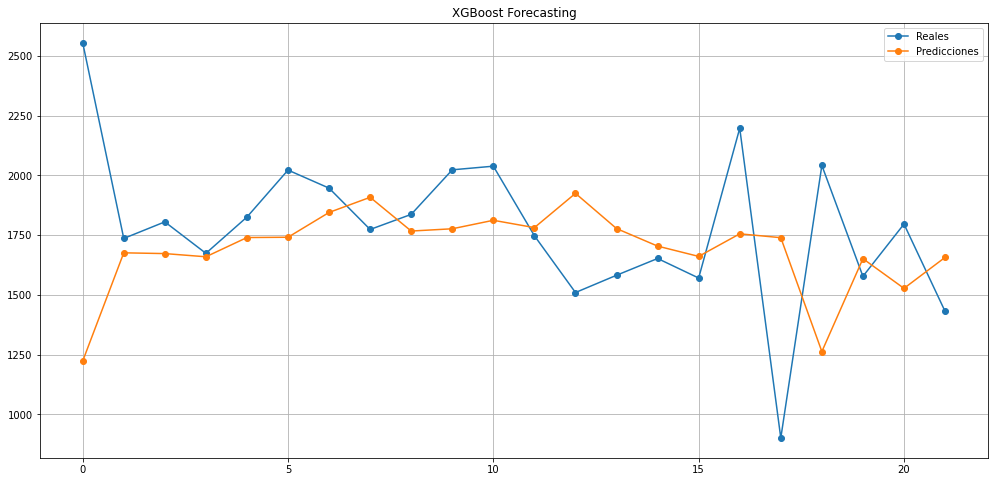

In [33]:
# Plotting the predictions

plt.figure(figsize=(17,8))
plt.plot(Y_test, label = 'Reales', marker = 'o')
plt.plot(Y_pred, label = 'Predicciones', marker = 'o')
plt.title('XGBoost Forecasting')
plt.grid(True)
plt.legend()
plt.show()

# Pendiente Bagging